In [1]:
%pylab inline
import numpy as np
import seaborn as sns
from tqdm import tqdm
from laika.lib.coordinates import LocalCoord, ecef2geodetic


Populating the interactive namespace from numpy and matplotlib


In [2]:
# A practical way to confirm the accuracy of laika's processing
# is by downloading some observation data from a CORS station
# and confirming our position estimate to the known position
# of the station.


# We begin by initializing an AstroDog
from laika import AstroDog
dog = AstroDog()

In [3]:
# Building this cache takes forever just copy it from repo

from shutil import copyfile
import os
cache_directory = '/tmp/gnss/cors_coord/'
try:
  os.mkdir('/tmp/gnss/')
except:
  pass
try:
  os.mkdir(cache_directory)
except:
  pass
copyfile('cors_station_positions', cache_directory + 'cors_station_positions')

'/tmp/gnss/cors_coord/cors_station_positions'

In [4]:
from datetime import datetime
from laika.gps_time import GPSTime
from laika.downloader import download_cors_station
from laika.rinex_file import RINEXFile
from laika.dgps import get_station_position


# We can use helper functions in laika to download  the station's observation
# data for a certain time and its known exact position.
station_name = 'slac'
# Note: Files older than approximately 1 year generally use Hatanaka compression
# This will result in a download failure
time = GPSTime.from_datetime(datetime(2020,1,7))
slac_rinex_obs_file = download_cors_station(time, station_name, dog.cache_dir)

obs_data = RINEXFile(slac_rinex_obs_file)
slac_exact_postition = get_station_position('slac')

In [5]:
import laika.raw_gnss as raw
# Now we have the observation data for the station we can process 
# it with the astrodog.

rinex_meas_grouped = raw.read_rinex_obs(obs_data)
rinex_corr_grouped = []
for meas in tqdm(rinex_meas_grouped):
  proc = raw.process_measurements(meas, dog=dog)
  corr = raw.correct_measurements(meas, slac_exact_postition, dog=dog)
  rinex_corr_grouped.append(corr)

100%|██████████| 2880/2880 [01:44<00:00, 27.54it/s]


No orbit data found for prn : G04 flagging as bad
No orbit data found for prn : R12 flagging as bad
No orbit data found for prn : R25 flagging as bad
No orbit data found for prn : R26 flagging as bad
No orbit data found for prn : R27 flagging as bad
No orbit data found for prn : R28 flagging as bad
pulling from http://ftpcache.comma.life/cddis-gsfc-nasa-gov/gnss/data/daily/2017/007/17g/brdc0070.17g.Z to /tmp/gnss/daily_nav/2017/007/17g/brdc0070.17g
cache download failed, pulling from ftp://cddis.gsfc.nasa.gov/gnss/data/daily/2017/007/17g/brdc0070.17g.Z to /tmp/gnss/daily_nav/2017/007/17g/brdc0070.17g
pulling from http://ftpcache.comma.life/ftp-glonass-iac-ru/MCC/PRODUCTS/17008/final/Sta19310.sp3 to /tmp/gnss/russian_products/17008/final/Sta19310.sp3
cache download failed, pulling from ftp://ftp.glonass-iac.ru/MCC/PRODUCTS/17008/final/Sta19310.sp3 to /tmp/gnss/russian_products/17008/final/Sta19310.sp3
pulling from http://ftpcache.comma.life/cddis-gsfc-nasa-gov/gnss/products/1931/igs1931

In [6]:
# Using laika's WLS solver we can now calculate position
# fixes for every epoch (every 30s) over 24h.

ests = []
for corr in tqdm(rinex_corr_grouped[:]):
  fix, _ = raw.calc_pos_fix(corr)
  ests.append(fix)
ests = array(ests)

100%|██████████| 2880/2880 [02:11<00:00, 21.96it/s]


The error of the median position is NED:
[ 0.07873913  0.14659687 -0.29446328]


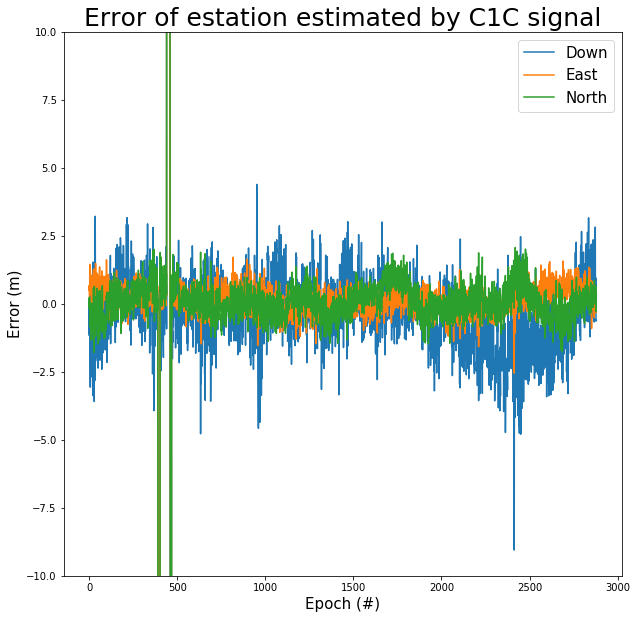

In [7]:
# Now we plot the error of every fix in NED (North, East, Down)
# coordinates, we see clearly that the Down axis is noisier, 
# this is to be expected as the VDOP is generally much larger
# than the HDOP.

conv = LocalCoord.from_ecef(slac_exact_postition)
errors_ned = conv.ecef2ned(ests[:,:3])
figsize(10,10)
plot(errors_ned[:,2], label='Down');
plot(errors_ned[:,1], label='East');
plot(errors_ned[:,0], label='North');
title('Error of estation estimated by C1C signal', fontsize=25);
ylim(-10,10);
xlabel('Epoch (#)', fontsize=15);
ylabel('Error (m)', fontsize=15);
legend(fontsize=15);


# The error of the median position compared to the true
# position is ~0.5m with this technique. This is about what
# we would expect. Without using carrier phase measurements
# we do not expect better results.
print('The error of the median position is NED:')
print(np.median(errors_ned, axis=0))

In [8]:
# Out of curiousity we repeat the previous experiment, but we use
# the C2P signal. Just to make sure we get similar results. And while
# we're at it lets compare the residuals of GLONASS and GPS.
from laika.helpers import get_constellation


ests, errs, residuals_gps, residuals_glonass = [], [], [], []
for corr in tqdm(rinex_corr_grouped[:]):
  sol = raw.calc_pos_fix(corr, signal='C2P')
  residuals_gps.append(raw.pr_residual([c for c in corr if get_constellation(c.prn) == 'GPS'], signal='C2P')(np.append(slac_exact_postition, sol[0][3:])))
  residuals_glonass.append(raw.pr_residual([c for c in corr if get_constellation(c.prn) == 'GLONASS'], signal='C2P')(np.append(slac_exact_postition, sol[0][3:])))
  ests.append(sol[0])
ests = array(ests)

100%|██████████| 2880/2880 [02:00<00:00, 23.86it/s]


The error of the median position is NED:
[ 0.23263012  0.09786348 -0.10135632]


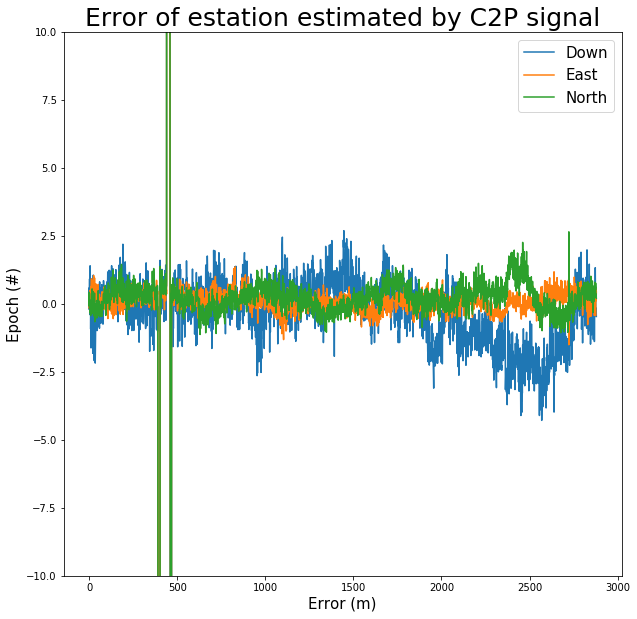

In [9]:
# We plot the error again and see similar results,
# this gives us confidence that the different signals
# are being processed correctly.

conv = LocalCoord.from_ecef(slac_exact_postition)
errors_ned = conv.ecef2ned(ests[:,:3])
figsize(10,10)
plot(errors_ned[:,2], label='Down');
plot(errors_ned[:,1], label='East');
plot(errors_ned[:,0], label='North');
title('Error of estation estimated by C2P signal', fontsize=25);
ylim(-10,10);
ylabel('Epoch (#)',fontsize=15);
xlabel('Error (m)',fontsize=15);
legend(fontsize=15);

print('The error of the median position is NED:')
print(np.median(errors_ned, axis=0))

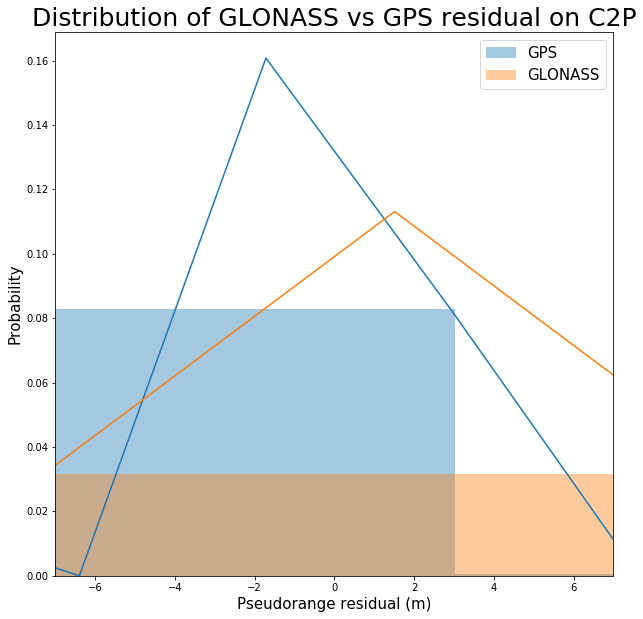

In [10]:
# When we look at at the residual distributions of GLONASS
# and GPS here we see the distributions are very similar,
# showing that that both constellations provide correct
# and good signal. Intrestingly there is a non-trival negative
# bias on both constellations. This bias must be attriubted to
# something that is not sattelite or constellation specific since
# it is equally present on GLONASS and GPS. It is probably caused
# by modelling errors in the ionosphere/troposhere or multipath.

sns.distplot(np.concatenate(residuals_gps)[np.isfinite(np.concatenate(residuals_gps))], label='GPS');
sns.distplot(np.concatenate(residuals_glonass)[np.isfinite(np.concatenate(residuals_glonass))],label='GLONASS');
xlim(-7, 7);
xlabel('Pseudorange residual (m)',fontsize=15);
ylabel('Probability',fontsize=15);
title('Distribution of GLONASS vs GPS residual on C2P', fontsize=25);
legend(fontsize=15);